<h1><center>PREDICTING GENTRIFICATION IN CHICAGO</center></h1>

# Model Testing

### Loading of data:

In [50]:
import pandas as pd
import numpy as np

In [2]:
x_vals = pd.read_csv("../Data/features.csv", header = 0, index_col = 0)
y_vals = pd.read_csv("../Data/Data Determine Y/Zipcode_Yvalues.csv", header = 0, index_col = 0)

In [3]:
y_vals['Zipcode'] = y_vals['Zipcode'].astype('int32')
y_vals = y_vals.rename(columns={'Zipcode': 'zip', 'Gentrified2020':2012})
y_vals = pd.melt(y_vals, id_vars=['zip'], value_vars=[2012], var_name='year')

In [4]:
# Merge datasets and clean data
df = x_vals[x_vals['year'] == 2012].merge(y_vals, how='left', on=['zip', 'year'])
df = df.dropna(axis=1)
df = df.iloc[:,2:]

# Change percentages to percentage format
df.college = df.college * 0.01
df.non_hip_white = df.non_hip_white * 0.01
df.vacancy = df.vacancy * 0.01
df.eviction_rate = df.eviction_rate * 0.01

In [5]:
# Define features and labels
X = df.iloc[:, :13]
y = df.iloc[:, 13]

In [71]:
# Feature variable statistics after cleaning
X.describe()

,property_crime,violent_crime,homicide,college,non_hip_white,vacancy,med_rent,perc_under_18,perc_over_65,unemp_rate,eviction_rate,gardens,park_area
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,10481.528914,2717.639266,40.382026,0.395242,0.394033,0.147250,1060.017241,0.187463,0.021378,0.128764,0.018384,0.724138,14.509855
std,6471.561689,2662.755466,47.924665,0.265429,0.289354,0.070940,317.502838,0.079118,0.015115,0.071903,0.010298,0.450851,25.011043
min,809.693400,58.914900,0.000000,0.060547,0.005805,0.053519,690.000000,0.028037,0.003782,0.020738,0.003943,0.000000,0.000000
25%,5074.829200,711.849500,4.158100,0.166370,0.097274,0.094473,861.250000,0.117615,0.011837,0.082117,0.011077,0.000000,3.381782
50%,9929.516900,1640.182700,17.277850,0.344956,0.408271,0.125757,929.000000,0.213305,0.016862,0.110585,0.016435,1.000000,6.429110
75%,15524.720475,4182.333550,70.069475,0.600502,0.625932,0.180582,1109.500000,0.257073,0.024744,0.167104,0.023348,1.000000,13.232485
max,23338.244400,8625.991900,141.520900,0.895145,0.867348,0.388759,1923.000000,0.297232,0.069227,0.345020,0.050545,1.000000,131.852813


In [7]:
# Labels
y.unique()

array([0, 1], dtype=int64)

### Data pre-processing:

In [8]:
import sklearn
import sklearn.model_selection
from sklearn.preprocessing import RobustScaler

In [9]:
# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Split into train and test sets
rndm_state = 999
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
                                    X_scaled, y,
                                    train_size=0.65,
                                    random_state=rndm_state)

# Feature Importance

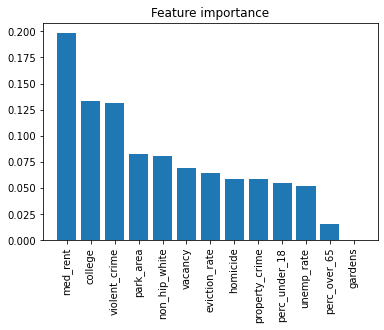

In [73]:
#### Determine feature importance
from sklearn.ensemble import RandomForestClassifier
rndm_state = 999
feat_labels = X.columns[0:]
forest = RandomForestClassifier(n_estimators=50, 
                                max_depth=2, 
                                random_state=rndm_state)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot of feature importance taken from:
# Raschka, Liu, and Mirjalili - "Machine Learning with PyTorch and Scikit-Learn"
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]),
       importances[indices],
       align = 'center')
plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], 
           rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Model 1: Neural Net

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
torch.manual_seed(999)

In [12]:
# Create PyTorch dataset and dataloader
training_X = torch.FloatTensor(X_train)
training_y = torch.FloatTensor(y_train.to_numpy())
train_ds = TensorDataset(training_X, training_y)
batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [13]:
# Create sequential neural network model

# Implimentation decisions for using dropout (decision of rate, pairing with weight 
# regularization, and larger network) taken from https://bit.ly/3m8zYLE.

model = nn.Sequential(
    nn.Linear(13, 13),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(13, 26),
    nn.ReLU(),
    nn.Dropout(p=0.7),
    nn.Linear(26, 40),
    nn.ReLU(),
    nn.Dropout(p=0.7),
    nn.Linear(40, 50),
    nn.ReLU(),
    nn.Linear(50, 1))

In [14]:
# Define loss function and SGD optimizer
L2_reg_lambda = 0.05
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay = L2_reg_lambda)

#### Model training and testing

In [15]:
# Define training function
# Idea for logging histories of loss an accuracies taken from:
# Raschka, Liu, and Mirjalili - "Machine Learning with PyTorch and Scikit-Learn"

def train(model, num_epochs, epoch_log, train_dl, X_test, y_test):
    # Loss and accuracy history lists
    loss_train = [0] * num_epochs
    acc_train = [0] * num_epochs
    loss_valid = [0] * num_epochs
    acc_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        loss_log = 0
        for x_batch, y_batch in train_dl:
            #Train model
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # Update training history for batch
            loss_train[epoch] += loss.item()
            pred_correct = ((pred>=0.5).float() == y_batch).float()
            acc_train[epoch] += pred_correct.mean()
        
        # Report training loss and accuracy histories for epoch
        loss_train[epoch] /= len(train_dl)
        acc_train[epoch] /= len(train_dl)
        if (epoch + 1) % epoch_log == 0:
            print(f"Epoch {epoch + 1} loss :", loss_train[epoch])
        
        # Report testing loss and accuracy histories for epoch
        pred = model(X_test)[:, 0]
        loss = loss_fn(pred, y_test)
        loss_valid[epoch] = loss.item()
        pred_correct = ((pred>=0.5).float() == y_test).float()
        acc_valid[epoch] = pred_correct.mean()
        
    return loss_train, acc_train, loss_valid, acc_valid            

In [17]:
testing_X = torch.FloatTensor(X_test)
testing_y = torch.FloatTensor(y_test.to_numpy())

In [18]:
epochs = 125
print_every = 25
history = train(model, epochs, print_every, train_dl, testing_X, testing_y)

Epoch 25 loss : 0.49463257354659
Epoch 50 loss : 0.4908491457636292
Epoch 75 loss : 0.4875046127551311
Epoch 100 loss : 0.4912158983784753
Epoch 125 loss : 0.4896974168919228


#### Model evaluation and performance measures

In [74]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Epochs')

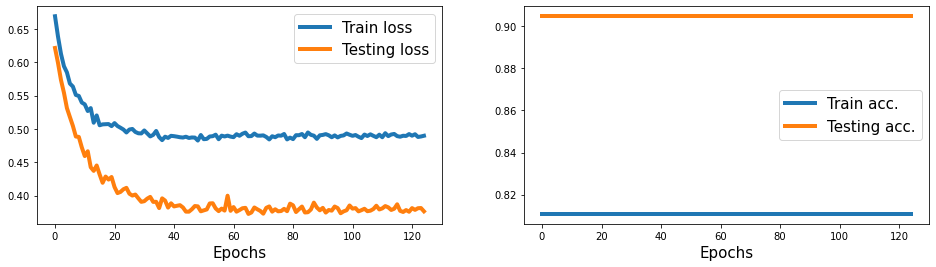

In [19]:
# Create plots for loss and accuracy
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[2], lw=4)
plt.legend(['Train loss', 'Testing loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[1], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Testing acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [20]:
with torch.no_grad():
    pred = model(testing_X)[:, 0]
    loss = loss_fn(pred, testing_y)
    print(f"Test MSE: ", loss.item())

Test MSE:  0.3774506747722626


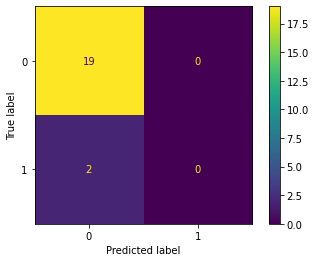

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
with torch.no_grad():
    y_pred = model(testing_X)[:, 0]
    y_pred = (y_pred>=0.5).float()
    cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Model 2: Linear SVM

In [35]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [36]:
rndm_state = 999
svm = LinearSVC(C=0.7, random_state=rndm_state)
svm.fit(X_train, y_train)

LinearSVC(C=0.7, random_state=999)

In [38]:
print(svm.score(X_test, y_test))

0.8571428571428571


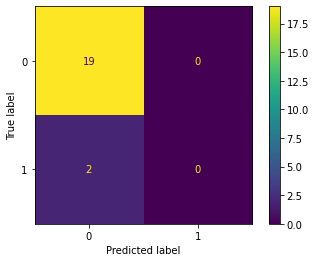

In [58]:
# Calculate Linear SVM predicted probabilities
clf = CalibratedClassifierCV(svm)
clf.fit(X_train, y_train)
y_probs = clf.predict_proba(X_test)

# Calculate confusion matrix
y_pred = (y_probs[:,1]>=0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Model 3: K-NN

In [70]:
len(feat_labels)

12

In [ ]:
# NN precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()